In [1]:
import os
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

import json
from PIL import Image, ImageDraw
import torch

In [2]:
def load_coco_data(image_dir, annotation_file):
    with open(annotation_file) as f:
        data = json.load(f)
    
    images = data['images']
    annotations = data['annotations']
    categories = data['categories']
    
    # 카테고리 ID와 이름을 매핑하는 딕셔너리 생성
    category_dict = {cat['id']: cat['name'] for cat in categories}
    # 이미지 ID를 key로 하고, 파일명을 value로 하는 딕셔너리 생성
    image_dict = {img['id']: img['file_name'] for img in images}
    
    # 바운딩 박스 정보를 이미지 ID별로 구성
    bbox_dict = {}
    seg_dict = {}  # 세그멘테이션 정보를 저장할 딕셔너리
    for ann in annotations:
        image_id = ann['image_id']
        bbox = ann['bbox']  # [x_min, y_min, width, height]
        cat_name = category_dict[ann['category_id']]  # 카테고리 이름 추가
        segmentation = ann.get('segmentation', None)  # 세그멘테이션 정보 가져오기
        
        # 바운딩 박스 정보 추가
        if image_id in bbox_dict:
            bbox_dict[image_id].append((bbox, cat_name))
        else:
            bbox_dict[image_id] = [(bbox, cat_name)]
        
        # 세그멘테이션 정보 추가
        if segmentation:  # 세그멘테이션 정보가 있는 경우
            if image_id in seg_dict:
                seg_dict[image_id].append((segmentation, cat_name))
            else:
                seg_dict[image_id] = [(segmentation, cat_name)]

    return image_dict, bbox_dict, seg_dict

In [3]:
def segmentation_bbox(image_path, bboxes, segmentations):
    image = Image.open(image_path)  # 이미지 로딩
    if image.mode != 'RGBA':
        image = image.convert('RGBA')
    draw = ImageDraw.Draw(image)
    
    # 기존 바운딩 박스 그리기 코드
    for bbox, cat_name in bboxes:
        draw.rectangle([(bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3])], outline="red")
        draw.text((bbox[0], bbox[1]-10), cat_name, fill="red")
    
    # 세그멘테이션 그리기 코드 추가
    for segmentation, cat_name in segmentations:
        # 폴리곤 좌표로 세그멘테이션 그리기
        for poly in segmentation:
            #각각의 x, y 좌표 쌍으로 이루어진 튜플의 리스트를 생성
            poly = [(poly[i], poly[i+1]) for i in range(0, len(poly), 2)]
            draw.polygon(poly, outline="red", fill=(255, 0, 0, 50))

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

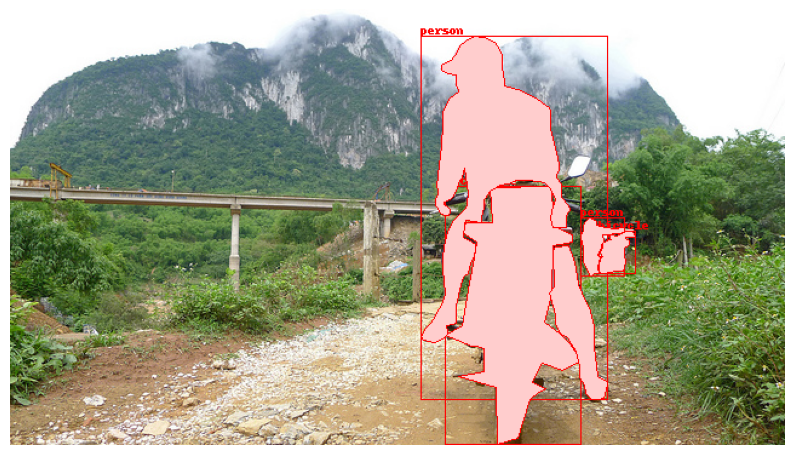

In [4]:
# 데이터 로딩
image_dir = './train2017/'
annotation_file = 'C:/Users/JOOYONKJ/Desktop/AI/side project/annotations/instances_train2017.json'

# 이미지 디렉토리와 어노테이션 파일에서 COCO 데이터를 로드
image_dict, bbox_dict, seg_dict = load_coco_data(image_dir, annotation_file)

# 데이터셋에서 첫 번째 이미지의 ID를 로드
first_image_id = next(iter(image_dict))

# 첫 번째 이미지 위에 바운딩 박스가 겹쳐진 세그멘테이션을 표시
segmentation_bbox(
    image_dir + '/' + image_dict[first_image_id],  # 첫 번째 이미지의 경로
    bbox_dict[first_image_id],                     # 첫 번째 이미지의 바운딩 박스 좌표
    seg_dict[first_image_id]                       # 첫 번째 이미지의 세그멘테이션 마스크
)
